# Libraries Used

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sklearn
import tensorflow_hub as hub
import scipy.sparse as sparse
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import RidgeCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrut\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrut\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Exploring the Dataset

>*  Bgg-15m-reviews is the Dataset that we are going to use to perform the Rating prediction

In [2]:
df_game_reviews = pd.read_csv('bgg-15m-reviews.csv')

> This is how our dataset looks like. It has approximately 16M rows and 6 columns
  * <strong>name:</strong> It's the name of the particular game that has received the rating 
  * <strong>ID:</strong> It's the ID of that particular game
  * <strong>comment:</strong> It's the review received by the User
  * <strong>rating:</strong> It's the rating given by the User
  * <strong>user:</strong> User name that has reviewed or rated the game

In [3]:
df_game_reviews.head()

,Unnamed: 0,user,rating,comment,ID,name
0,0,Torsten,10.0,NaN,30549,Pandemic
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
3,3,Mike Mayer,10.0,NaN,30549,Pandemic
4,4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic


>* Below is the shape of our Dataset. As we can see it is humongous 

In [4]:
df_game_reviews.shape

(15823269, 6)

>* Our main motto in this problem is to form a feature vector for a given comment, if a comment is not present then the data row is of least use to us.
>* So in that kind of a scenario we want to remove all the data rows that have no comment, so that we can build the feature
vectors for the existing ones.

In [5]:
df_game_reviews.dropna(subset=['comment'], inplace=True)

>* Now if we look at the shape of our data set, it is drastically reduced,it is 20% of the original dataset.
>* We started with 15M reviews no after processing we have ended up with approximately 3M reviews.

In [6]:
df_game_reviews.shape

(2995023, 6)

>* If we compare our dataset head with dataset head before processing, the difference is evident.
>* We can see that rows with comment as NaN are removed from the dataset.

In [7]:
df_game_reviews.head()

,Unnamed: 0,user,rating,comment,ID,name
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
4,4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic
5,5,cfarrell,10.0,Hey! I can finally rate this game I've been pl...,30549,Pandemic
8,8,gregd,10.0,Love it- great fun with my son. 2 plays so far...,30549,Pandemic


>* And we are going to do the same with ratings. 
>* We will remove all the rows in the dataset that have Nan ratings

In [8]:
df_game_reviews.dropna(subset=['rating'], inplace=True)

>* Below is the shape of our dataset after removing the Nan Ratings. 
>* We can observe that there is no change after this processing, means all the reviews that are present in the Dataset having
  respective ratings for them.

In [9]:
df_game_reviews.shape

(2995023, 6)

> These are the number of Unique ratings present in the Dataset

In [10]:
len(df_game_reviews.rating.unique())

4384

## Visualizing the Data 
>* Below is the visualization of the data by Histogram using Ratings column.
>* From the below chart it is clearly evident that there are significant amount of reveiws that have ratings in between
    6-10.
>* Highest amount of reviews have ratings between 7-8.
>* Least amount of reveiws have ratings between 1-2.

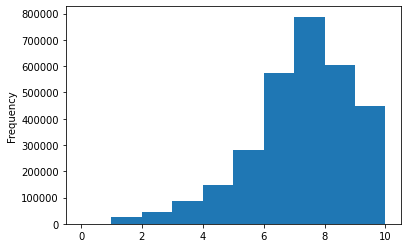

In [11]:
df_game_reviews['rating'].plot(kind='hist')
plt.show()

# Data Preprocessing 

>* First I have made a custom list of stopwords because the word list given by nltk has negative sentiment words it like
    "not", "shouldn't", "couldn't", etc.,
>* When we are predicting the ratings the most important things is we need sentiment specific words to be present in the
    dataset, so that whatever the model we might run. it will try to learn the sentiment and predict the rating accordingly
>* In my custom stopwords list I have removed the words that have a specific sentiment, so that model will have a chance to 
    learn and predict accurate ratings
>* I have used WordNetLemmatizer so that the words of different inflected forms are considered as same word. This gives us a
    better edge in achieving our goal

In [32]:
new_stopwords_list = ['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'your','yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that',"that'll",'these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','nor','only','own','same','so','than','too','very','s','t','can','will','just','should',"should've",'now','d','ll','m','o','re','ve','y','ain','aren','ma','shan',"shan't"]
new_stopwords_dict = dict.fromkeys(new_stopwords_list, None)
lemmatizer = WordNetLemmatizer()

### Preprocessing steps needed to perform on the Data
> These steps are performed so that we have the information that is useful and significant to us:
  >* First step is to remove the html tags from the data.
  >* Second step is to divide the words like **shouldn't, couldn't** to **should not, could not**.
  >* Third step is to remove numbers in the text as they are not useful to us in this scenario and strip the whitespaces.
  >* Fourth step is to convert the whole text in to lower case.
  >* Fifth step is to tokenize the text. In this step I have used word_tokenize method to split the text and form them into          tokens.
  >* Sixth step is to retain the words that are not in my custom sttop words list.
  >* Seventh step is to lemmatize the words so that different inflections of the word are represented as same word.
  >* Eigth step is to join them as a string and now they are ready to be fed to any Word embedding method we want.

In [31]:
def preprocessing_tfIDF(df_row):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    df_row = re.sub(cleanr, '', df_row)
    df_row = re.sub(r"n't",' not' , df_row)
    df_row = re.sub('[^.a-zA-Z\s]',' ',df_row).strip()
    df_row = df_row.lower()
    text_tokens = word_tokenize(df_row)
    df_row = [word for word in text_tokens if word not in new_stopwords_dict]
    df_row = [lemmatizer.lemmatize(word) for word in df_row]
    return " ".join(df_row)

>* Below is a sample of how our preprocessing method works...

In [50]:
preprocessing_tfIDF('i love <br>   games </br?>that are')

'love game'

# Now we start applying  preprocessing method on our Dataset
>* Before applying it we will make a copy of the original dataset so that, whatever changes we do will not reflect in the
   main Dataset

In [ ]:
df_reviews_TFIDF = df_game_reviews.copy()

>* Now we apply the preprocessing method on the comment column for every row in the Dataset.

In [ ]:
%%time
df_reviews_TFIDF['comment'] = df_reviews_TFIDF['comment'].apply(preprocessing_tfIDF)

In [ ]:
df_reviews_TFIDF.head(10)

>* As the Dataset is having around 3M reviews this preprocessing step takes alot of time.
>* Inorder to avoid re-running the method, we will pickle the preprocessed data once the procedure is done, so that it can
   be used later if needed.

In [ ]:
pickle.dump(df_reviews_TFIDF, open( "preprocessed_revs_TFIDF.p", "wb" ))

>* Loading the pickled file

In [18]:
df_reviews_tfidf_pkl = pickle.load( open( "preprocessed_revs_TFIDF.p", "rb" ) )

>* All the ratings present in the Dataset are continous values, So using them we can perform Regression task.
>* What if we want to perform a classification task as well? So for the purpose I have added another column 
   of ratings that are rounded to the nearest integer, so that this column can be used for Classification task

In [19]:
df_reviews_tfidf_pkl['RoundedRatings'] = df_reviews_tfidf_pkl['rating'].astype(int)

>* Now we can see our cleaned Dataset below 

In [20]:
df_reviews_tfidf_pkl.head(10)

,Unnamed: 0,user,rating,comment,ID,name,RoundedRatings
1,1,mitnachtKAUBO-I,10.0,hand favorite new game bgg con . played time r...,30549,Pandemic,10
2,2,avlawn,10.0,tend either love easily tire co op game . pand...,30549,Pandemic,10
4,4,Mease19,10.0,amazing co op game . play mostly wife game ca ...,30549,Pandemic,10
5,5,cfarrell,10.0,hey finally rate game playtesting couple year ...,30549,Pandemic,10
8,8,gregd,10.0,love great fun son . play far looking forward,30549,Pandemic,10
9,9,calbearfan,10.0,fun fun game . strategy required definitely ac...,30549,Pandemic,10
11,11,treece keenes,10.0,not know balanced thing . absolutely amazing ....,30549,Pandemic,10
12,12,davecort,10.0,best collaborative multi player game . period .,30549,Pandemic,10
13,13,PopeBrain,10.0,play play family game player . finally coopera...,30549,Pandemic,10
16,16,zunyer,10.0,thematic brisk game well balanced creates palp...,30549,Pandemic,10


>* As the data is still huge and due to the computational and training time constraints, I sampled the data and took
   50% of the data for training my models. 
>* Approximately after sampling my dataset is 1.5M reviews which is not a small
   amount and we still a have chance to build a model that predicts the rating of the review accurately.
    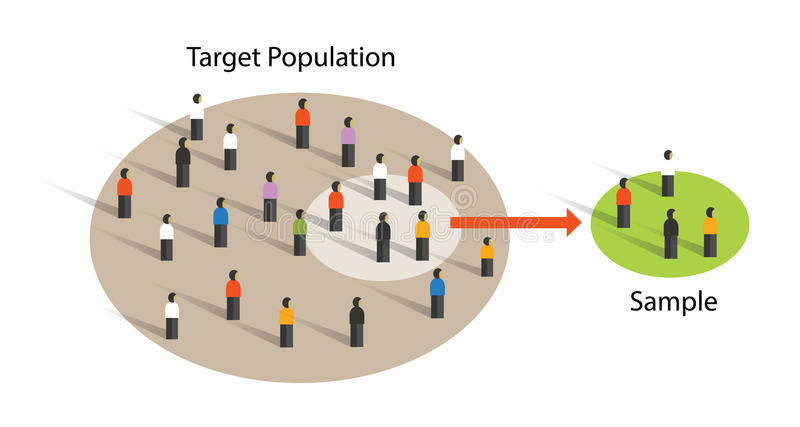

In [21]:
sampled_df = df_reviews_tfidf_pkl.sample(frac=0.5, replace=True, random_state=1)

>* Here we are converting the comments and ratings to list so that we can split the data in to train and test and 
   run our models accordingly.

In [22]:
reviews_tfdif = sampled_df.comment.tolist()
ratings_tfidf = sampled_df.rating.tolist()

>* Splitting the data into train and test 
>* Here we specified the test size as 0.1, so we have around 150k reveiws for test, which is huge.
>* I specified random_state parameter as 1 because in the coming lines of code, I'm going to split the data again 
   for classification task, so that we have consistency in the train test split in reviews

In [23]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(reviews_tfdif,ratings_tfidf, test_size =0.1,random_state=1)

### For this project I'm using word embedding technique called TF-IDF Vectorizer
>* TF-IDF represents Term Frequency-Inverse Documnet Frequency
>* The main aim of the TF-IDF Vectorizer is to convert the corpus of data into feature matrix.
>* It states the importance of a word based on the occurence of the word in the document multiplied by the number of documents
   the word appeared in 
   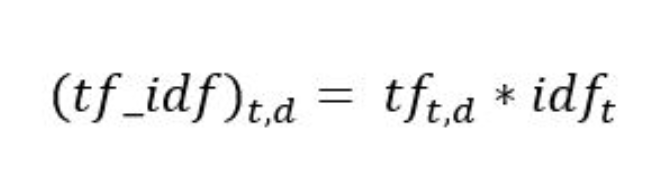
   

In [24]:
tfidf_vectorizer = TfidfVectorizer()
train_feat_vector = tfidf_vectorizer.fit_transform(X_train_tfidf)
test_feat_vector = tfidf_vectorizer.transform(X_test_tfidf)

>* We pickle this vectorizer because, we need to use the vocabulary of this vectorizer to make predicitons in future

In [22]:
pickle.dump(tfidf_vectorizer, open("TFIDF_Vectorizer.p","wb"))

# Models Implemented
### From here on we are going to dive into the model training and implementation.
>* For this project the models that I have chosen are:
    > Regression methods:
        * Random Forest Regressor (Ensemble method)
        * Ridge Regression
        * Lasso Regression
        * Linear Regression
        * Stochastic Gradient Descent Regressor (SGD Regressor)
    > Classification  method:
        * Multinomial Naive Bayes Classifier

# Random Forest Regressor

>* This an ensemble learning method that is used for both classification and regression tasks.
>* Underlying operation of Random Forests is they construct multiple decision trees and output the mean or average predicition of the individual trees.
>* Random forests perform better than the conventional Decision Trees.
>* To make predicitons for given review, one of my models is Random Forest Regressor.
   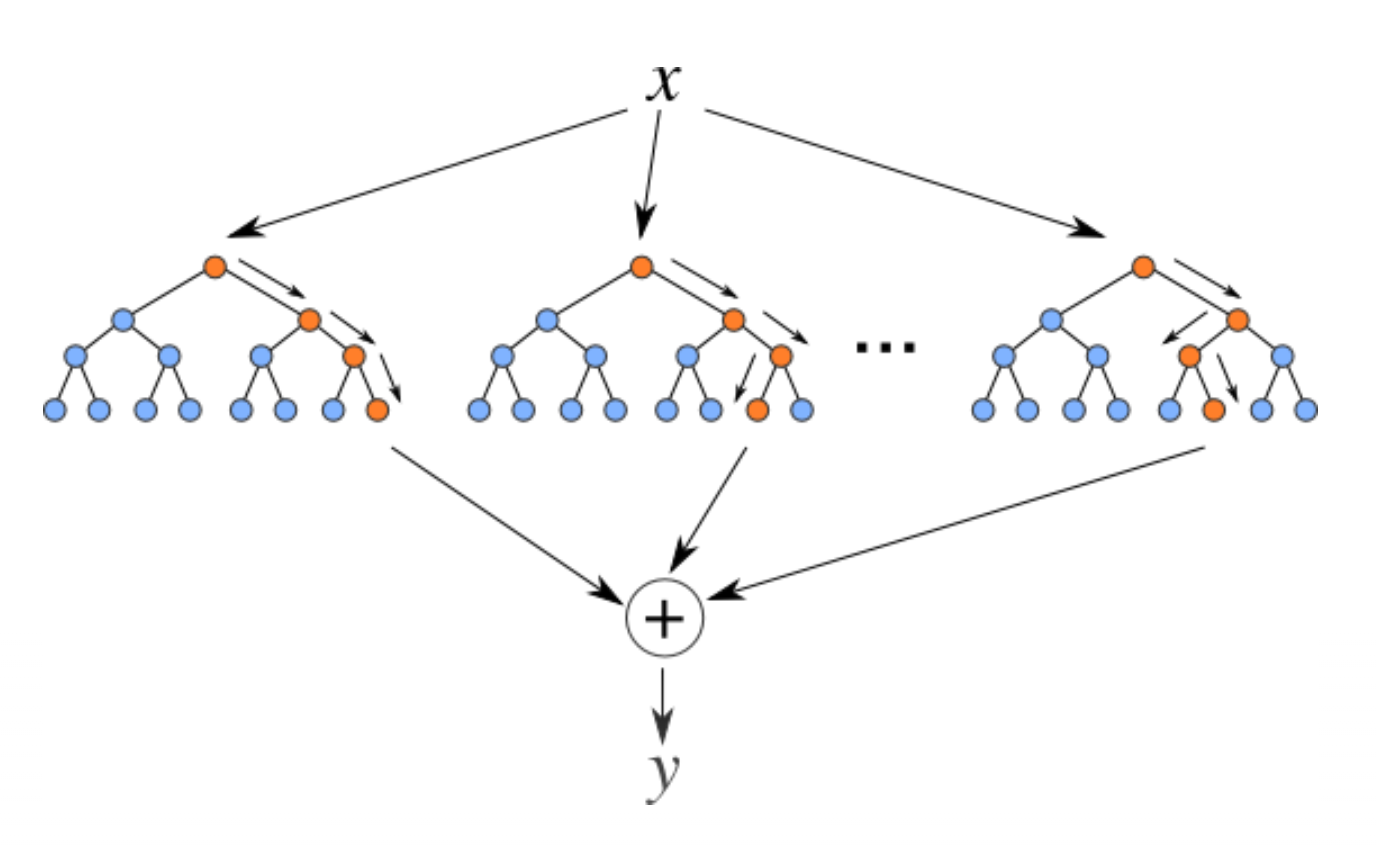

In [23]:
random_forest_reg = RandomForestRegressor(verbose=1, n_jobs=-1)
random_forest_reg.fit(train_feat_vector,y_train_tfidf)
random_forest_reg = pickle.load(open("Random_forest_Model (1).p","rb"))

In [24]:
test_feat_vector_RFG = pickle.load(open("Test_feature_vector.p","rb"))
true_preds_RFG = pickle.load(open("True_Predictions.p","rb"))

In [25]:
random_forest_preds = random_forest_reg.predict(test_feat_vector_RFG)
error_random_forest_reg = mean_squared_error(true_preds_RFG,random_forest_preds)
print("Mean Squared error for Random Forest Regressor is :", error_random_forest_reg)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s


Mean Squared error for Random Forest Regressor is : 1.813680271910354


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   17.4s finished


>* We can see that the mean squared error of the model is 1.813. Now let us see how other models perform and depending on the metrics we will select the final model

# Ridge Regression 

>* Ridge regression is used to solve the problem of Oridanry Least Squares by penalizing the coefficients. What all it does is 
   it regularizes the coefficents so that the weights are not exploded.
>* And that Regularizing parameter is controlled by **α** 
>* And to get the better idea of the performance of the model, I performed Cross Validation and hyperparameter tuning. so that 
   the final model we get will be the model with particular hyperparameter having lowest error.
   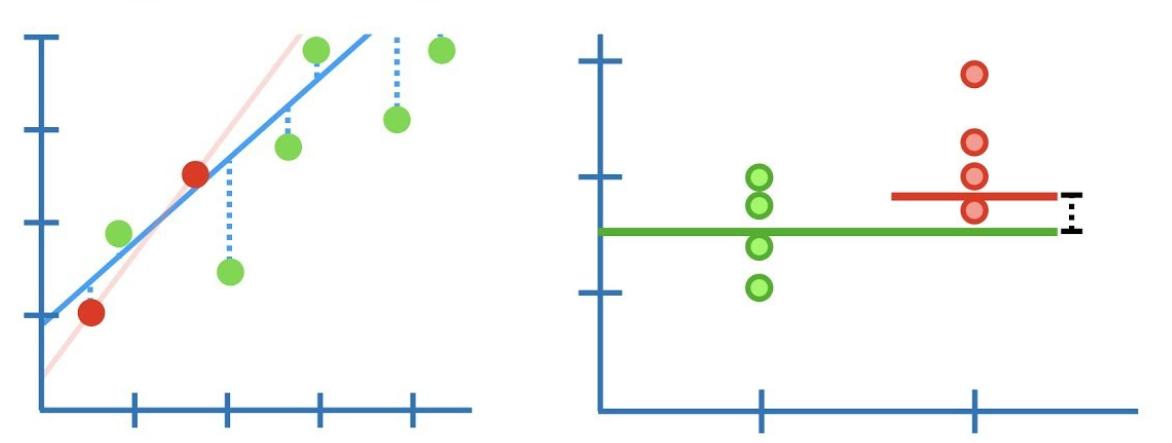

In [26]:
%%time
ridge_reg = RidgeCV(alphas=[0.001,0.01,0.1,1], cv=5).fit(train_feat_vector,y_train_tfidf)

Wall time: 25min 8s


In [27]:
ridge_pred = ridge_reg.predict(test_feat_vector)
error_ridge = mean_squared_error(y_test_tfidf, ridge_pred)
print("Mean Squared error for Ridge Regression is :", error_ridge)

Mean Squared error for Ridge Regression is : 1.9873422475281517


>* We can see that Mean Squared error for this model is 1.98 which slightly more than Random Forest Regressor.

In [28]:
pickle.dump(ridge_reg, open( "Ridge_Regression_Model.p", "wb" ))

# Lasso Regression

>* Another model I used to predict the rating is Lasso Regression. Here also I have performed Hyperparameter tuning and 
   Cross Validation to get better estimate of the performance of the model.
   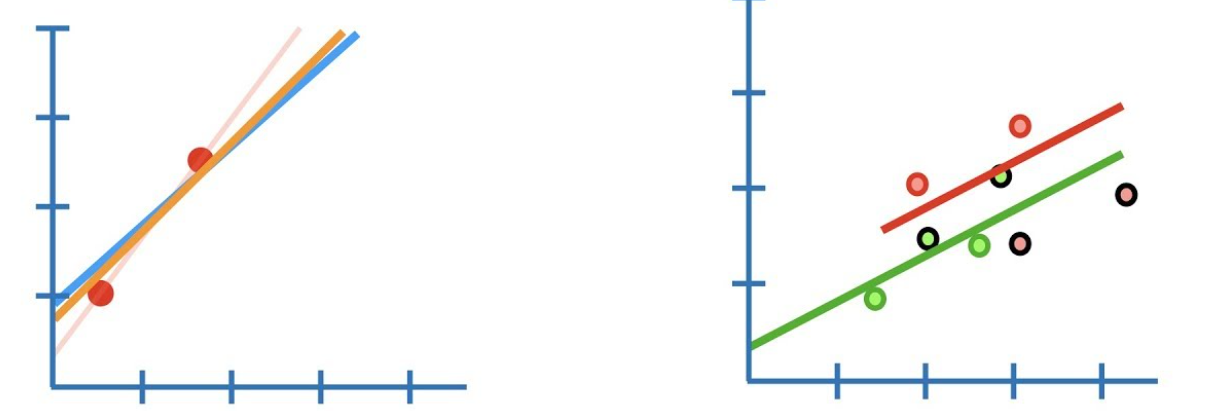

In [29]:
%%time
lasso_reg = LassoCV(alphas=[1,0.1,0.01,0.001], cv=5, n_jobs=-1).fit(train_feat_vector,y_train_tfidf)

Wall time: 2h 43min 5s


In [30]:
pickle.dump(lasso_reg, open( "Lasso_Regression_Model.p", "wb" ))

In [31]:
lasso_pred = lasso_reg.predict(test_feat_vector)
error_lasso = mean_squared_error(y_test_tfidf, lasso_pred)
print("Mean Squared error for Lasso Regression is :", error_lasso)


Mean Squared error for Lasso Regression is : 2.6062899105869355


>* We can see that Mean Squared error for this model is 2.60

# Linear Regression 

>* Linear Regression is a model used to find the relationship between dependent variable and given set of independent variable
>* As there are no hyperparameters for this model I have done 5-Fold cross validation on the Dataset using this model
   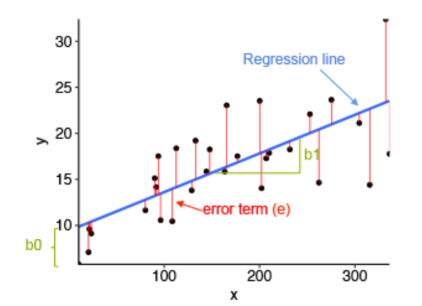

In [32]:
%%time
linear_reg = LinearRegression(n_jobs=-1).fit(train_feat_vector,y_train_tfidf)

Wall time: 1h 9min 13s


In [33]:
pickle.dump(linear_reg, open( "Linear_Regression_Final_Model.p", "wb" ))

In [34]:
linear_pred = linear_reg.predict(test_feat_vector)
error_linear = mean_squared_error(y_test_tfidf, linear_pred)
print("Mean Squared error for Linear Regression is :", error_linear)

Mean Squared error for Linear Regression is : 2.347778545915451


In [35]:
%%time
ln_model = LinearRegression(n_jobs=-1)
linear_scores = cross_val_score(ln_model,train_feat_vector,y_train_tfidf, cv=5)

Wall time: 4h 26min 21s


>* Mean squared error for this model is 2.34

# Multinomial Naive Bayes
>* Multinomial Naive Bayes (Multivariate Event model) is one of the event models of Naive Bayes which is usually used for text    classification problems. 
>* Here also similarly I have performed 5-fold cross validation with hyperparameter tuning, here the hyperparameter is **α**      which is the smoothing parameter
>* Below are the accuracy values of various hyperparameters. If we observe closely we can see that **α** = 0.001 has better performance when compared to others
>* But this algorithm is not on par with Random Forest Regressor

In [6]:
reviews_MNB = df_reviews_tfidf_pkl.comment.tolist()
ratings_MNB = df_reviews_tfidf_pkl.RoundedRatings.tolist()

In [7]:
X_train_MNB, X_test_MNB, y_train_MNB, y_test_MNB = train_test_split(reviews_MNB, ratings_MNB, test_size=0.1, random_state=1)

In [8]:
tfidf_Vectorizer_MNB = TfidfVectorizer()
train_feat_vector_MNB = tfidf_Vectorizer_MNB.fit_transform(X_train_MNB)
test_feat_vector_MNB = tfidf_Vectorizer_MNB.transform(X_test_MNB)

In [9]:
%%time
multinomial_naive_bayes_1 = MultinomialNB(alpha=1)
mnb_scores_1 = cross_val_score(multinomial_naive_bayes_1,train_feat_vector_MNB,y_train_MNB, cv=5)

Wall time: 16.5 s


In [10]:
mnb_scores_1

array([0.28740651, 0.2868556 , 0.28726554, 0.28786468, 0.28734901])

In [40]:
pickle.dump(multinomial_naive_bayes_1, open( "Multinomial_Naive_Bayes_1.p", "wb" ))

In [11]:
%%time
multinomial_naive_bayes_2 = MultinomialNB(alpha=0.1)
mnb_scores_2 = cross_val_score(multinomial_naive_bayes_2,train_feat_vector_MNB,y_train_MNB, cv=5)

Wall time: 15.6 s


In [12]:
mnb_scores_2

array([0.30101428, 0.29941533, 0.3007212 , 0.30148543, 0.30094935])

In [42]:
pickle.dump(multinomial_naive_bayes_2, open( "Multinomial_Naive_Bayes_2.p", "wb" ))

In [13]:
%%time
multinomial_naive_bayes_3 = MultinomialNB(alpha=0.01)
mnb_scores_3 = cross_val_score(multinomial_naive_bayes_3,train_feat_vector_MNB,y_train_MNB, cv=5)

Wall time: 16.3 s


In [14]:
mnb_scores_3

array([0.30288033, 0.30143534, 0.30277646, 0.30298236, 0.30307881])

In [44]:
pickle.dump(multinomial_naive_bayes_3, open( "Multinomial_Naive_Bayes_3.p", "wb" ))

In [15]:
%%time
multinomial_naive_bayes_4 = MultinomialNB(alpha=0.001)
mnb_scores_4 = cross_val_score(multinomial_naive_bayes_4,train_feat_vector_MNB,y_train_MNB, cv=5)

Wall time: 16.1 s


In [16]:
mnb_scores_4

array([0.30244443, 0.30102541, 0.30246483, 0.30269113, 0.30293784])

In [46]:
pickle.dump(multinomial_naive_bayes_4, open( "Multinomial_Naive_Bayes_4.p", "wb" ))

# SGD Regressor

>* Stochastic Gradient Descent is an Optimization model used to optimize the Loss/ Cost function.
>* Here I have used SGD Regressor on the Dataset
>* Below are the scores after performing 5-Fold Cross Validation

In [25]:
%%time
sgd_reg = SGDRegressor(max_iter=1000, n_iter_no_change=1000)
sgd_scores = cross_val_score(sgd_reg,train_feat_vector,y_train_tfidf, cv=5 )

C:\Users\shrut\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shrut\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shrut\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shrut\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Wall time: 30min 22s


C:\Users\shrut\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [26]:
sgd_scores

array([0.31863599, 0.32012684, 0.31937196, 0.31881581, 0.31768506])

## Testing a few reviews with my final model that is Random Forest Regressor

In [27]:
random_forest_reg_test = pickle.load(open("Random_forest_Model (1).p","rb"))

In [29]:
random_vectorizer = pickle.load(open("Random_forest_vectorizer.p","rb"))

> **Positive Review** 

In [43]:
test_str = "The game is fantastic :) ....!!@@@@ and I loved playing it in group <3<3 Also it gathers people a lot"
prep_test = preprocessing_tfIDF(test_str)
test_vectorizer = TfidfVectorizer(vocabulary=random_vectorizer.vocabulary_)
prep_test_vector = test_vectorizer.fit_transform([prep_test])
prediction = random_forest_reg_test.predict(prep_test_vector)
round(prediction[0],1)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


8.5

> **Negative Review**

In [48]:
test_str = "The game is not upto the mark :) ....!!@@@@ and I hated playing it in groups."
test_vectorizer = TfidfVectorizer(vocabulary=random_vectorizer.vocabulary_)
prep_test_vector = test_vectorizer.fit_transform([prep_test])
prediction = random_forest_reg_test.predict(prep_test_vector)
round(prediction[0],1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


4.0

# Challenges
>* As the dataset was very huge, it took a lot of time to preprocess the data. As preprocessing of the Data is a crucial step I had to go back and forth a couple of times to remove some unwanted preprocessing which i made, which costed me alot of time.
>* For the training of the model I sampled the Data and used only 50%, due to computational constraints.
>* Main challenge that I have faced in implementing this project is training the model. Models like Ridge, Naive Bayes and SGD took a lot less time. But having limited Computational facility I had to run Random forest Regressor on another laptop with same train test parameters, so that i can build models with less complexity in my notebook.
>* To overcome the above challenges I used the concept of pickling wherever I felt it's necessary.
>* As I have used TF-IDF Vectorizer the feature vector is very large, this added more complexity to my computational constraint problem
>* After training the Random Forest Regressor I got the model file of around 3.5GB which I was not able to upload it to git, Though I tried uploading it through GITLFS it was not successful. So for that reason I had to use my second best model for web application deployment which is Ridge Regression.

# Contribution
>* In the references that I have considered, this problem statement is solved as a Classification problem. But I implemented both Regression and Classification models, but my main effort was in developing Regression models.


# Conclusion
>* Based on the metric **MSE** "Mean Squared Error" I conclude that Random Forest Regressor as my model.

# References
>* https://www.dreamstime.com/stock-illustration-sample-population-statistics-research-survey-methodology-selection-concept-vector-image97171869
>* https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
>* https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
>* https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/
>* https://levelup.gitconnected.com/random-forest-regression-209c0f354c84
>* https://www.youtube.com/watch?v=NGf0voTMlcs
>* https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string/12982689
>* https://www.kaggle.com/oldelephant/term-project-data-mining
>* https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/
>* https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f